## 스마트 정수장 알고리즘 - 약품 공정 - 전처리

In [2]:
import numpy as np
import pandas as pd
import datetime
import scipy
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import r_regression
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import pickle
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

if platform.system() == "Darwin":  #
    plt.rc("font", family="AppleGothic")
else:
    plt.rc("font", family="NanumGothic")

fe = fm.FontEntry(
    fname=r"/usr/share/fonts/truetype/nanum/NanumGothic.ttf",  # ttf 파일이 저장되어 있는 경로
    name="NanumGothic",
)  # 원하는 폰트 설정
fm.fontManager.ttflist.insert(0, fe)  # Matplotlib에 폰트 추가

plt.rcParams.update({"font.size": 18, "font.family": "NanumGothic"})  # 폰트 설정

plt.rcParams["axes.unicode_minus"] = False

---
### 데이터 전처리

#### 데이터의 단위

> 수집되는 데이터에 따라 단위가 다를 수 있다.

**주요 인자의 단위** </br>
<img src='2_1_units.png' width='150px'/>

**단위 변환** </br>

<img src='2_1_units_transform.png' width='200px'/>

현재 응집제 주입량은 mL/min 으로 측정된다. </br>
이를 주입률로 바꾸려고 하면 다음과 같은 처리가 필요하다.

In [3]:
file = "SN_2020.csv"
load_df = pd.read_csv(file)
load_df.head(5)

,시간,원수 알칼리도,원수 전기전도도,원수 pH,원수 탁도,원수 수온,3단계 원수 유입 유량,4단계 원수 유입 유량,3단계 1계열 응집제 주입량,3단계 1계열 응집제 주입률,...,4단계 2번 약품 주입기 주입률 제어값,4단계 2계열 약품 주입기 ON,3단계 혼화수 pH,4단계 혼화수 pH,3단계 침전지 탁도,4단계 침전지 탁도 1,여과지 탁도,3단계 회수 유량,4단계 회수 유량,4단계 침전지 탁도 2
0,2020-01-01 09:01:00,53.77500,219.8438,8.261750,2.568750,4.60625,8357.50,8952.50,933.3333,13.39897,...,13.0,1.0,7.877625,7.753375,0.255000,0.361375,0.045375,1.35000,0.0000,0.325332
1,2020-01-01 09:02:00,53.68125,219.4375,8.258250,2.631250,4.60000,8408.75,8928.75,933.3333,13.31705,...,13.0,1.0,7.872375,7.742875,0.249375,0.365625,0.050750,1.51875,0.0000,0.329158
2,2020-01-01 09:03:00,53.68750,219.8438,8.258250,2.618750,4.60000,8386.25,8970.00,933.3333,13.33714,...,13.0,1.0,7.871500,7.747250,0.251875,0.363625,0.051250,1.35000,0.0000,0.327358
3,2020-01-01 09:04:00,53.68750,220.0000,8.255625,2.609375,4.60625,8346.25,9075.00,933.3333,13.63389,...,13.0,1.0,7.875875,7.745500,0.251250,0.357125,0.046625,1.01250,0.0000,0.321506
4,2020-01-01 09:05:00,53.71875,219.8438,8.253000,2.581250,4.61875,8338.75,9038.75,933.3333,12.38729,...,13.0,1.0,7.868000,7.739375,0.250625,0.362750,0.054250,746.88750,970.4688,0.326570


In [4]:
df = load_df[
    ["3단계 원수 유입 유량", "3단계 1계열 응집제 주입량", "3단계 1계열 응집제 주입률"]
]

In [5]:
df.loc[:, "3단계 1계열 응집제 주입률 계산값"] = (
    (df["3단계 1계열 응집제 주입량"] * 1e-3 * 60)
    / (df["3단계 원수 유입 유량"] / 2)
    * 1000
).copy()
df

/tmp/ipykernel_39076/1600406574.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "3단계 1계열 응집제 주입률 계산값"] = (


,3단계 원수 유입 유량,3단계 1계열 응집제 주입량,3단계 1계열 응집제 주입률,3단계 1계열 응집제 주입률 계산값
0,8357.50,933.3333,13.39897,13.401136
1,8408.75,933.3333,13.31705,13.319458
2,8386.25,933.3333,13.33714,13.355194
3,8346.25,933.3333,13.63389,13.419200
4,8338.75,933.3333,12.38729,13.431269
...,...,...,...,...
510304,9208.75,1533.3334,18.05353,19.980997
510305,9278.75,1533.3334,17.93260,19.830258
510306,9226.25,1550.0000,18.13338,20.159870
510307,9208.75,1533.3334,17.99696,19.980997


---
### 2.2. 결측치/이상치 처리

> 실제 데이터에는 수많은 결측치와 이상치들이 존재한다. </br>
> 결측치/이상치가 얼마나 중요하게 작용하는 데이터인지 파악하고, </br>
> 이를 제거하거나 대체해주어야 학습이 아름답게 될 수 있다. </br>
> 결측치/이상치를 제거하는 방법에는 dropna </br>
> 결측치/이상치를 대체하는 방법에는 bfill, ffill, linear interpolation, extrapolation, polynomial interpolation 등이 있다.

In [6]:
cols = [
    "원수 탁도",
    "원수 pH",
    "원수 알칼리도",
    "원수 전기전도도",
    "원수 수온",
    "3단계 원수 유입 유량",
    "3단계 1계열 응집제 주입률",
    "3단계 침전지 탁도",
]
raw_df = load_df[cols]
raw_df.head(5)

,원수 탁도,원수 pH,원수 알칼리도,원수 전기전도도,원수 수온,3단계 원수 유입 유량,3단계 1계열 응집제 주입률,3단계 침전지 탁도
0,2.568750,8.261750,53.77500,219.8438,4.60625,8357.50,13.39897,0.255000
1,2.631250,8.258250,53.68125,219.4375,4.60000,8408.75,13.31705,0.249375
2,2.618750,8.258250,53.68750,219.8438,4.60000,8386.25,13.33714,0.251875
3,2.609375,8.255625,53.68750,220.0000,4.60625,8346.25,13.63389,0.251250
4,2.581250,8.253000,53.71875,219.8438,4.61875,8338.75,12.38729,0.250625


#### 2.2.1. 결측치 탐색

In [29]:
raw_df.isna().sum()

원수 탁도              7663
원수 pH                15
원수 알칼리도               4
원수 전기전도도              6
원수 수온              7663
3단계 원수 유입 유량         14
3단계 1계열 응집제 주입률       3
3단계 침전지 탁도         7663
dtype: int64

In [30]:
raw_df[raw_df["원수 탁도"].isna()]

,원수 탁도,원수 pH,원수 알칼리도,원수 전기전도도,원수 수온,3단계 원수 유입 유량,3단계 1계열 응집제 주입률,3단계 침전지 탁도
시간,,,,,,,,
2020-08-21 23:27:00,NaN,0.000000,0.00000,0.0000,NaN,0.00,0.00000,NaN
2020-08-24 06:05:00,NaN,7.747250,54.13750,192.2813,NaN,8760.00,24.82181,NaN
2020-08-24 06:06:00,NaN,7.729750,53.84375,192.3438,NaN,8823.75,24.94552,NaN
2020-08-24 06:07:00,NaN,7.746375,53.75625,192.3750,NaN,8812.50,24.86901,NaN
2020-08-24 06:08:00,NaN,7.730625,53.77500,192.4375,NaN,8803.75,24.25933,NaN
...,...,...,...,...,...,...,...,...
2020-12-18 15:46:00,NaN,0.000000,0.00000,0.0000,NaN,0.00,0.00000,NaN
2020-12-18 15:47:00,NaN,0.000000,0.00000,0.0000,NaN,0.00,0.00000,NaN
2020-12-18 16:48:00,NaN,0.000000,0.00000,0.0000,NaN,0.00,0.00000,NaN


#### 2.2.2. 이상치 탐색

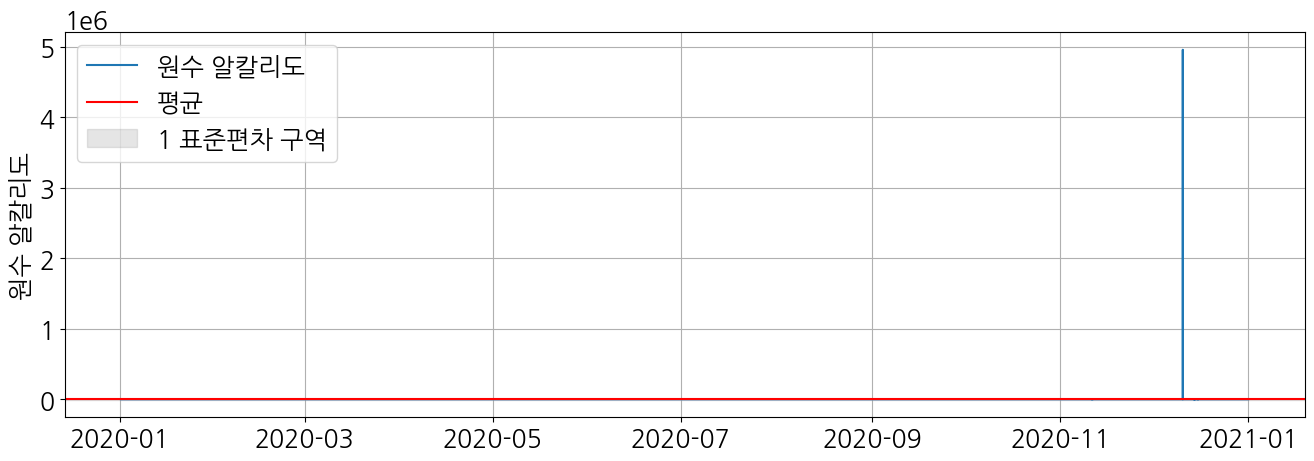

In [31]:
col = "원수 알칼리도"
fig = plt.figure(figsize=(16, 5))
plt.plot(raw_df.index, raw_df[col], label=col)
plt.axhline(mean[col], c="r", label="평균")
plt.axhspan(
    mean[col] - std[col],
    mean[col] + std[col],
    color="grey",
    alpha=0.2,
    label="1 표준편차 구역",
)
plt.ylabel(col)
plt.grid()
plt.legend()

In [32]:
con = raw_df["원수 알칼리도"] > 1e3
raw_df[con]

,원수 탁도,원수 pH,원수 알칼리도,원수 전기전도도,원수 수온,3단계 원수 유입 유량,3단계 1계열 응집제 주입률,3단계 침전지 탁도
시간,,,,,,,,
2020-12-10 19:07:00,3.5,1.696828,4959730.0,30.22617,7.1375,0.0,13.9568,0.345625


#### 2.2.3. 결측치/이상치 처리

##### 2.2.3.1. dropna

In [33]:
df = raw_df.copy()

In [34]:
df.shape

(510309, 8)

In [35]:
df[df["원수 탁도"].isna()].describe()

,원수 탁도,원수 pH,원수 알칼리도,원수 전기전도도,원수 수온,3단계 원수 유입 유량,3단계 1계열 응집제 주입률,3단계 침전지 탁도
count,0.0,7660.000000,7660.000000,7661.000000,0.0,7663.000000,7661.000000,0.0
mean,NaN,7.651587,53.124185,180.403620,NaN,11925.004404,22.786586,NaN
std,NaN,0.464216,5.516795,17.857148,NaN,1485.069244,2.846614,NaN
min,NaN,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,NaN
25%,NaN,7.570500,50.600000,172.156300,NaN,11418.750000,21.216210,NaN
50%,NaN,7.655375,53.062500,179.500000,NaN,12408.750000,23.885960,NaN
75%,NaN,7.743750,56.425000,187.906300,NaN,12870.000000,24.520300,NaN
max,NaN,8.416625,69.131250,236.812500,NaN,13643.750000,28.807070,NaN


In [36]:
df = df.dropna()

In [37]:
df.shape

(502631, 8)

In [38]:
con = df["원수 알칼리도"] > 1e4
df = df[~con]

In [39]:
df.isna().sum()

원수 탁도              0
원수 pH              0
원수 알칼리도            0
원수 전기전도도           0
원수 수온              0
3단계 원수 유입 유량       0
3단계 1계열 응집제 주입률    0
3단계 침전지 탁도         0
dtype: int64

#### Question: 이렇게 데이터를 삭제해도 될까요? 분석하는데 문제가 없을까요?

##### 2.2.3.2. bfill, ffill

In [40]:
df = raw_df.copy()

In [41]:
df = df.bfill().ffill()

In [42]:
df.isna().sum()

원수 탁도              0
원수 pH              0
원수 알칼리도            0
원수 전기전도도           0
원수 수온              0
3단계 원수 유입 유량       0
3단계 1계열 응집제 주입률    0
3단계 침전지 탁도         0
dtype: int64

In [43]:
df.shape

(510309, 8)

##### 2.2.3.3. linear interpolation

In [44]:
df = raw_df.copy()

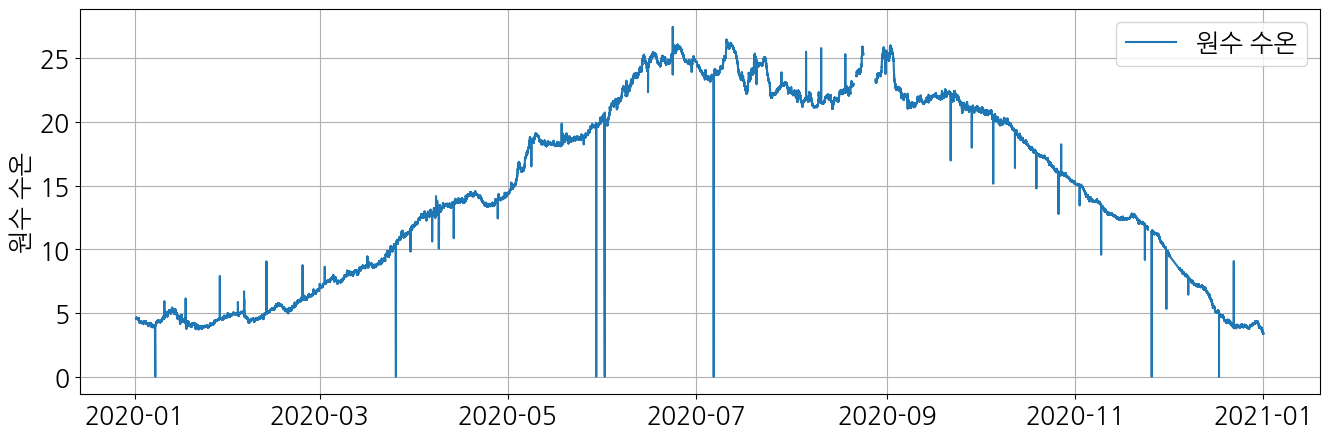

In [45]:
col = "원수 수온"
fig = plt.figure(figsize=(16, 5))
plt.plot(df.index, df[col], label=col)
plt.ylabel(col)
plt.grid()
plt.legend()

In [46]:
tmp = df["원수 수온"].dropna()
x = tmp.index.to_series().apply(lambda x: x.value * 1e-9 / 60 / 60)
y = tmp.to_numpy()
f1 = scipy.interpolate.interp1d(x, y)
newx = df.index.to_series().apply(lambda x: x.value * 1e-9 / 60 / 60)
newy = f1(newx)
df["원수 수온"] = newy

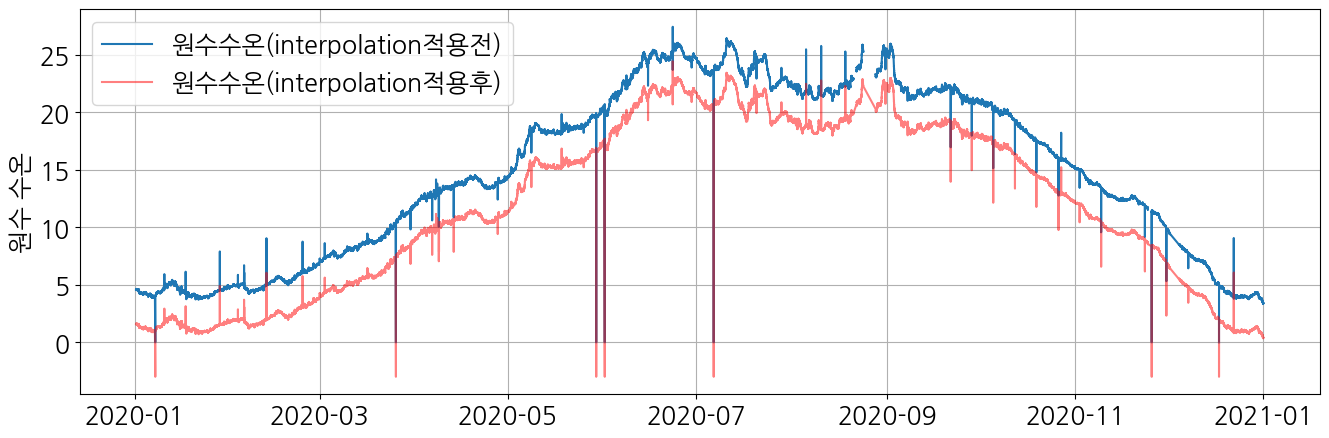

In [47]:
col = "원수 수온"
fig = plt.figure(figsize=(16, 5))
plt.plot(raw_df.index, raw_df[col], label="원수수온(interpolation적용전)")  # label=col,
plt.plot(df.index, df[col] - 3, c="r", alpha=0.5, label="원수수온(interpolation적용후)")
plt.ylabel(col)
plt.grid()
plt.legend()

---
### 2.3. 학습용 데이터 전처리

> 잘못 운영된 데이터를 학습 데이터로 사용하면 모델은 잘못된 운영을 그대로 모방할 것이다. </br>
> 이를 방지하기 위해 잘못 운영되었다고 판단되는 기간은 삭제를 해야한다.

In [48]:
df = raw_df.copy()

Text(0, 0.5, '3단계 침전지 탁도')

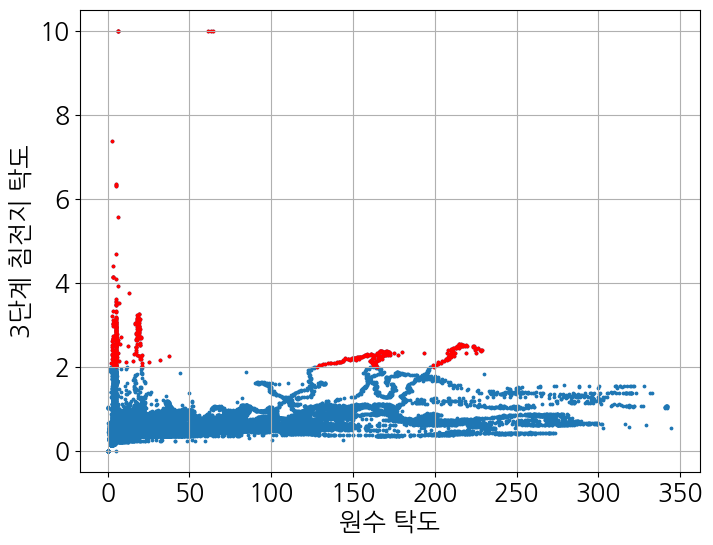

In [49]:
con = df["3단계 침전지 탁도"] > 2

plt.figure(figsize=(8, 6))
plt.scatter(df["원수 탁도"], df["3단계 침전지 탁도"], s=3)
plt.scatter(df.loc[con, "원수 탁도"], df.loc[con, "3단계 침전지 탁도"], s=3, c="r")
plt.grid()
plt.xlabel("원수 탁도")
plt.ylabel("3단계 침전지 탁도")

In [50]:
con = df["3단계 침전지 탁도"] > 2
df = df.loc[~con]
df

,원수 탁도,원수 pH,원수 알칼리도,원수 전기전도도,원수 수온,3단계 원수 유입 유량,3단계 1계열 응집제 주입률,3단계 침전지 탁도
시간,,,,,,,,
2020-01-01 09:01:00,2.568750,8.261750,53.77500,219.8438,4.60625,8357.50,13.39897,0.255000
2020-01-01 09:02:00,2.631250,8.258250,53.68125,219.4375,4.60000,8408.75,13.31705,0.249375
2020-01-01 09:03:00,2.618750,8.258250,53.68750,219.8438,4.60000,8386.25,13.33714,0.251875
2020-01-01 09:04:00,2.609375,8.255625,53.68750,220.0000,4.60625,8346.25,13.63389,0.251250
2020-01-01 09:05:00,2.581250,8.253000,53.71875,219.8438,4.61875,8338.75,12.38729,0.250625
...,...,...,...,...,...,...,...,...
2020-12-31 23:55:00,4.062500,8.088500,48.78750,196.5938,3.38125,9208.75,18.05353,0.349375
2020-12-31 23:56:00,2.937500,8.112125,49.00625,196.5313,3.39375,9278.75,17.93260,0.343125
2020-12-31 23:57:00,3.562500,8.092000,48.84375,196.8125,3.39375,9226.25,18.13338,0.348125


Text(0, 0.5, '3단계 침전지 탁도')

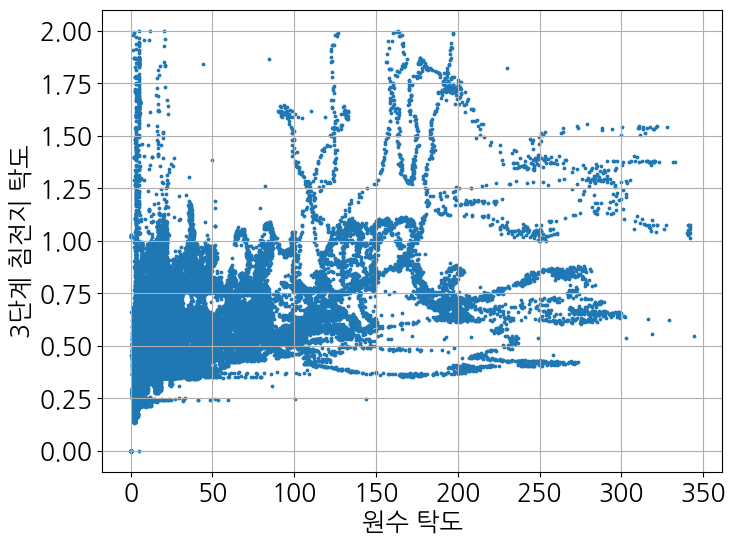

In [51]:
plt.figure(figsize=(8, 6))
plt.scatter(df["원수 탁도"], df["3단계 침전지 탁도"], s=3)
plt.grid()
plt.xlabel("원수 탁도")
plt.ylabel("3단계 침전지 탁도")

---
### 2.4. 새로운 피쳐 생성

> 모델에 필요하지만 수집하지 못하는 데이터는 기존 데이터로 생성하기도 한다. </br>
> 또한, 하나의 값만 필요한데 두 개 이상의 값이 존재하는 경우, 대표값을 사용하기도 한다.

#### 2.4.1. 침전지 체류 시간

In [52]:
df = raw_df.copy()

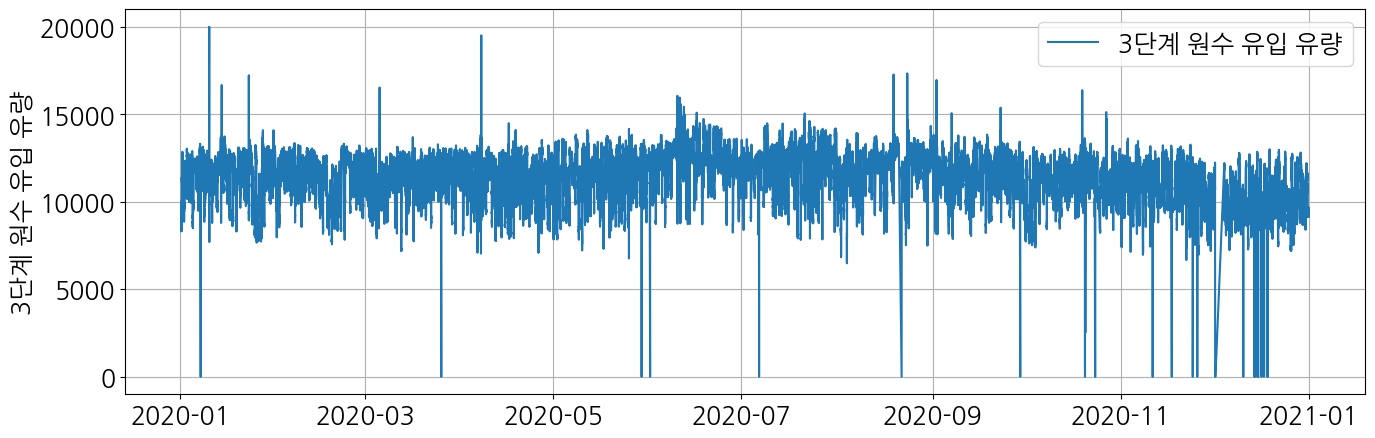

In [53]:
col = "3단계 원수 유입 유량"
fig = plt.figure(figsize=(16, 5))
plt.plot(df.index, df[col], label=col)
plt.ylabel(col)
plt.grid()
plt.legend()

In [54]:
con = df["3단계 원수 유입 유량"].between(5000, 17500)
df.loc[~con, "3단계 원수 유입 유량"] = np.nan
df = df.ffill().bfill()

In [55]:
sedimentation_tank_volume = 4.5 * 80 * 18 * 8
df["3단계 침전지 체류시간"] = sedimentation_tank_volume / df["3단계 원수 유입 유량"]

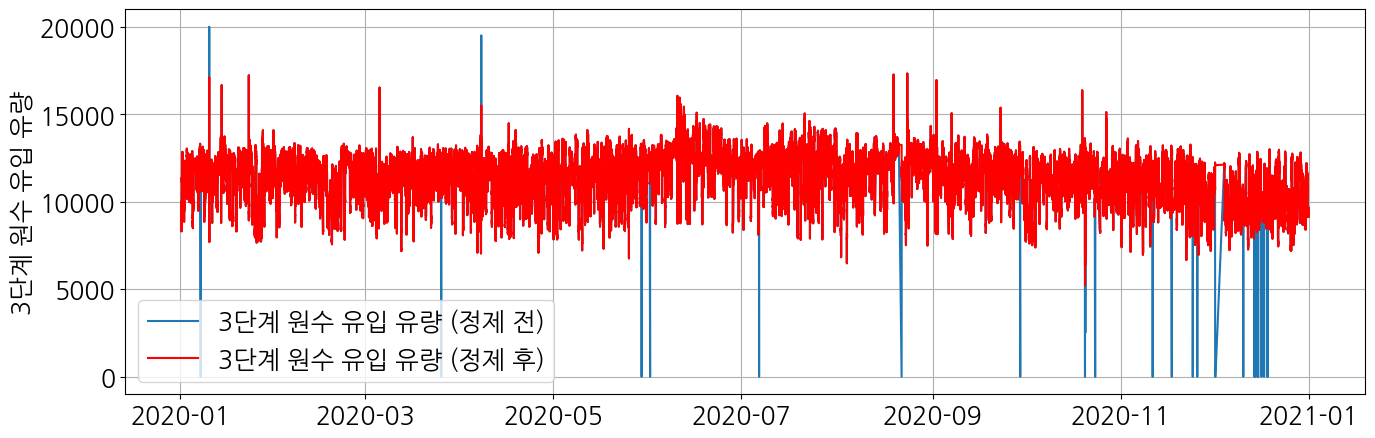

In [56]:
col = "3단계 원수 유입 유량"
fig = plt.figure(figsize=(16, 5))
plt.plot(raw_df.index, raw_df[col], label=f"{col} (정제 전)")
plt.plot(df.index, df[col], label=f"{col} (정제 후)", c="r")
plt.ylabel(col)
plt.grid()
plt.legend()

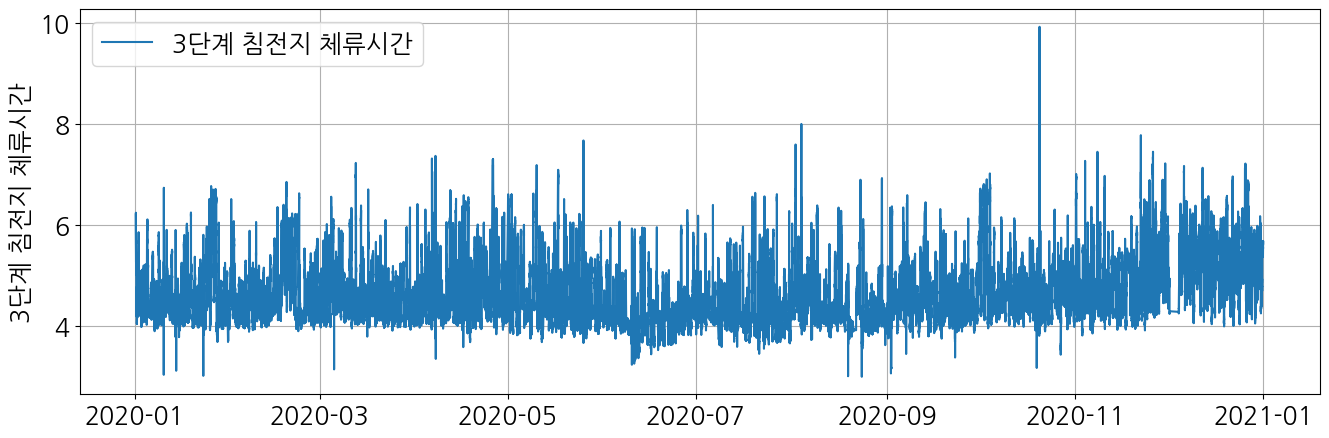

In [57]:
col = "3단계 침전지 체류시간"
fig = plt.figure(figsize=(16, 5))
plt.plot(df.index, df[col], label=f"{col}")
plt.ylabel(col)
plt.grid()
plt.legend()

#### 2.4.2. 대표값

In [58]:
df = load_df[["4단계 침전지 탁도 1", "4단계 침전지 탁도 2"]]

In [59]:
df

,4단계 침전지 탁도 1,4단계 침전지 탁도 2
시간,,
2020-01-01 09:01:00,0.361375,0.325332
2020-01-01 09:02:00,0.365625,0.329158
2020-01-01 09:03:00,0.363625,0.327358
2020-01-01 09:04:00,0.357125,0.321506
2020-01-01 09:05:00,0.362750,0.326570
...,...,...
2020-12-31 23:55:00,0.436500,0.392964
2020-12-31 23:56:00,0.434750,0.391389
2020-12-31 23:57:00,0.436125,0.392627


In [60]:
df.loc[:, "4단계 침전지 탁도"] = df.mean(axis=1).copy()

/tmp/ipykernel_929405/2763005692.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "4단계 침전지 탁도"] = df.mean(axis=1).copy()


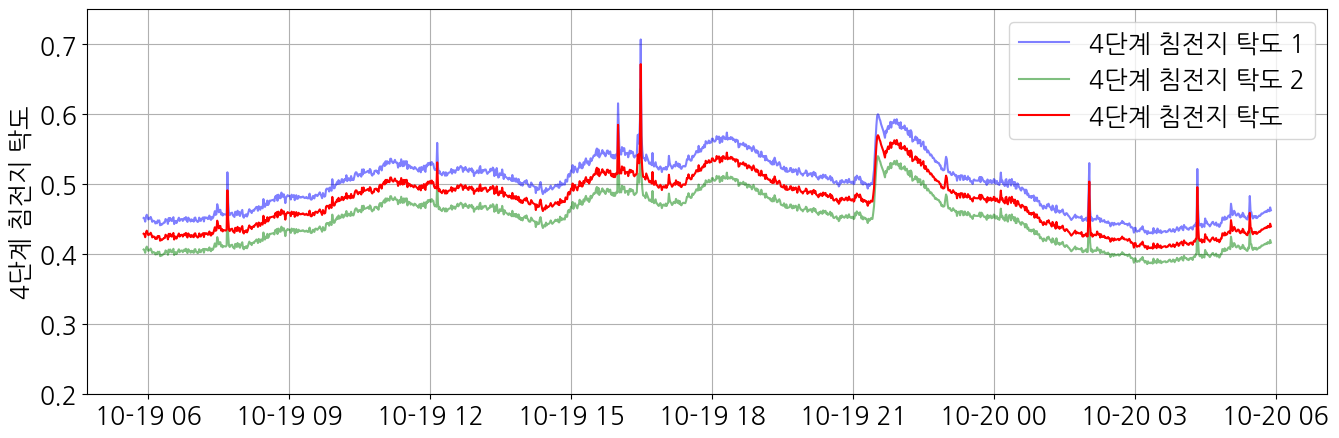

In [61]:
col = "4단계 침전지 탁도"
col1 = "4단계 침전지 탁도 1"
col2 = "4단계 침전지 탁도 2"
st = df.sample(1).index.item()
en = st + pd.Timedelta("1d")
tmp = df[df.index.to_series().between(st, en)]
fig = plt.figure(figsize=(16, 5))
plt.plot(tmp.index, tmp[col1], label=col1, c="b", alpha=0.5)
plt.plot(tmp.index, tmp[col2], label=col2, c="g", alpha=0.5)
plt.plot(tmp.index, tmp[col], label=col, c="r", alpha=1)
plt.ylim(0.2, 0.75)
plt.ylabel(col)
plt.grid()
plt.legend()

---
### 2.5. 리샘플

> 1분 단위의 데이터는 데이터의 양이 너무 많아 학습이 오래 걸릴 수 있다. </br>
> 또한 1분 단위의 데이터는 큰 오차를 가지고 있어 학습을 저해시킬 수 있다. </br>
> 데이터의 품질을 해치지 않는 선에서의 샘플링은 시간과 학습 품질을 높이는 데 도움이 된다.

In [62]:
df = raw_df.copy()

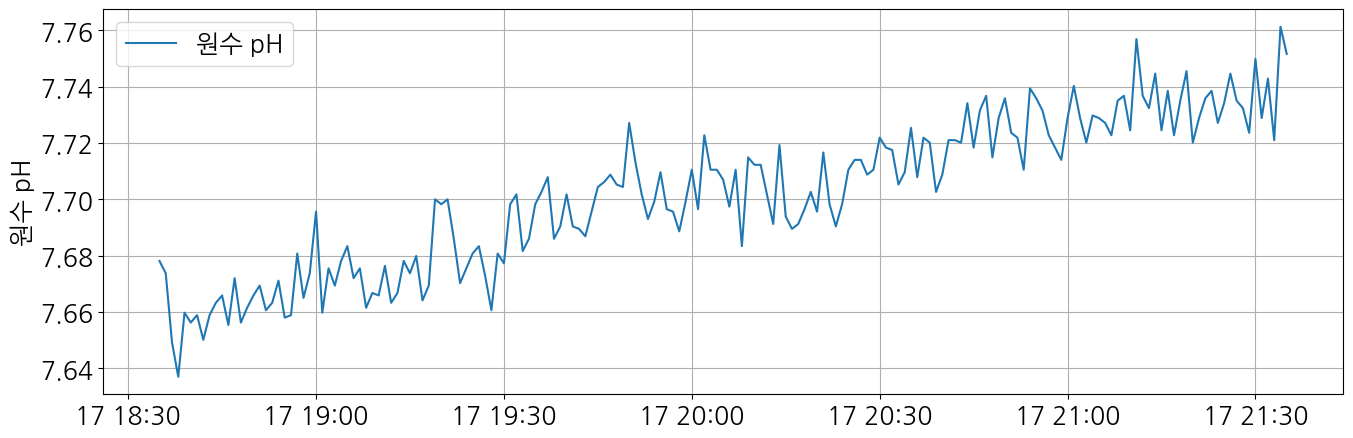

In [63]:
col = "원수 pH"
st = df.sample(1).index.item()
en = st + pd.Timedelta("3h")
tmp = df[df.index.to_series().between(st, en)]
fig = plt.figure(figsize=(16, 5))
plt.plot(tmp.index, tmp[col], label=col)
plt.ylabel(col)
plt.grid()
plt.legend()

In [64]:
df = df.resample("30T").mean().copy()

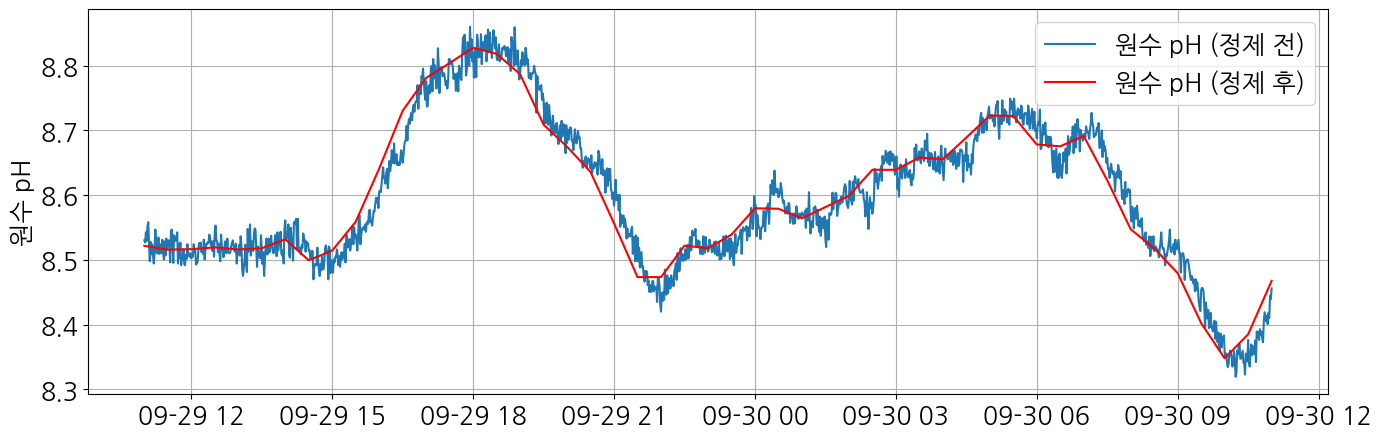

In [65]:
col = "원수 pH"
st = df.sample(1).index.item()
en = st + pd.Timedelta("1d")
tmp1 = raw_df[raw_df.index.to_series().between(st, en)]
tmp2 = df[df.index.to_series().between(st, en)]
fig = plt.figure(figsize=(16, 5))
plt.plot(tmp1.index, tmp1[col], label=f"{col} (정제 전)")
plt.plot(tmp2.index, tmp2[col], label=f"{col} (정제 후)", c="r")
plt.ylabel(col)
plt.grid()
plt.legend()

In [66]:
df

,원수 탁도,원수 pH,원수 알칼리도,원수 전기전도도,원수 수온,3단계 원수 유입 유량,3단계 1계열 응집제 주입률,3단계 침전지 탁도
시간,,,,,,,,
2020-01-01 09:00:00,2.603987,8.252306,53.504095,220.145497,4.609052,8398.879310,13.315704,0.252177
2020-01-01 09:30:00,2.572500,8.244133,52.989583,219.611483,4.594792,8659.041667,13.266208,0.253646
2020-01-01 10:00:00,2.472708,8.242529,52.888333,219.377110,4.573125,9625.125000,13.164503,0.259208
2020-01-01 10:30:00,2.455625,8.237046,53.173750,219.452113,4.567083,9914.083333,13.168461,0.264292
2020-01-01 11:00:00,2.522813,8.230133,53.041667,220.171897,4.574792,10182.083333,13.212828,0.266063
...,...,...,...,...,...,...,...,...
2020-12-31 21:30:00,3.008333,8.094362,48.312708,193.487517,3.426875,9395.750000,17.984970,0.379604
2020-12-31 22:00:00,2.935417,8.102792,49.039583,193.019817,3.438750,9512.291667,18.012765,0.380917
2020-12-31 22:30:00,2.856250,8.114342,49.090417,192.722940,3.412292,9443.208333,18.030680,0.369833
